### Lab 5. Quasi-Newton methods


1. Implement:

(a) Gauss-Newton method;

(b) Powell Dog Leg method;

(c) BFGS method.

2. Use the implemented methods to solve a nonlinear regression problem.

3. For each function:

(a) construct a table that shows the relationship between quantities iterations of the gradient method, number of function evaluations (if any), and number of function gradient evaluations (if any) for each method from the selected accuracy;

(b) draw a graph with data from the table (x-axis – accuracy, y-axis – number of iterations/function/gradient calculations);

4. Use arbitrary methods from previous laboratory work and compare them in terms of effectiveness with the methods implemented in this work.


#### 1

Implement:

(a) Gauss-Newton method;

(b) Powell Dog Leg method;


In [108]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown
from typing import Callable


In [109]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros((len(x), len(f(x))), dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f


In [110]:
def gauss_newton_method(
    f: Callable[[float, np.ndarray], float],
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    eps: float,
    max_it: int = 1000,
    info:bool=False
) -> np.ndarray:
    assert f(x[0], p0) is not None
    assert x.shape[0] > p0.shape[0]
    assert x.shape[0] == y.shape[0]
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    p = p0
    se_prev = np.inf
    for k in range(max_it):
        trajectory.append(p.copy())
        iters += 1
        calls += 1
        r = f(x, p) - y

        def fp(p):
            return f(x, p) - y

        grad_calls += 1
        J = np.array(grad(fp, p)).T
        # print(grad(fp,p))

        p = p - np.linalg.pinv(J.T @ J) @ J.T @ r
        se = np.sum(r**2)
        # print(f" {k}: SE {se}")
        diff = np.abs(se_prev**0.5 - se**0.5)
        if diff < eps:
           break
        se_prev = se

    trajectory.append(p.copy())
    if info:
        return p, iters, calls, grad_calls, trajectory
    else:
        return p


In [111]:
def test_gauss_newton():
    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 1
        return np.abs(x) ** k[0]

    x = np.linspace(-100, 100, 10)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2])) + np.random.random(x.shape)
    print(gauss_newton_method(f, np.array([1]), x, y, 1e-9))

    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 2
        return (np.abs(x) ** k[0]) + 10 * k[1]

    x = np.linspace(-100, 100, 11)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2, 1.5])) + np.random.random(x.shape)
    print(gauss_newton_method(f, np.array([1, 2]), x, y, 1e-9))


test_gauss_newton()


[2.00002033]
[1.99999731 1.56660085]


In [112]:
def brent_search(f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False):
    iter_count, f_call_count = 1, 1
    if b < a:
        a, b = b, a
    K = (3 - 5**0.5) / 2
    x = w = v = (a + b) / 2
    fw = fv = fx = f(x)
    deltax = 0.0
    iter = 0
    maxiter = 1e9
    while iter < maxiter:
        iter += 1
        iter_count += 1

        mintol = eps / 4
        tol1 = eps * np.abs(x) + mintol
        tol2 = 2.0 * tol1
        xmid = 0.5 * (a + b)
        # check for convergence
        if np.abs(x - xmid) < (tol2 - 0.5 * (b - a)):
            break
        if np.abs(deltax) <= tol1:
            if x >= xmid:
                deltax = a - x  # do a golden section step
            else:
                deltax = b - x
            rat = K * deltax
        else:  # do a parabolic step
            tmp1 = (x - w) * (fx - fv)
            tmp2 = (x - v) * (fx - fw)
            p = (x - v) * tmp2 - (x - w) * tmp1
            tmp2 = 2.0 * (tmp2 - tmp1)
            if tmp2 > 0.0:
                p = -p
            tmp2 = np.abs(tmp2)
            dx_temp = deltax
            deltax = rat
            # determine whether a parabolic step is acceptable or not:
            if (
                (p > tmp2 * (a - x))
                and (p < tmp2 * (b - x))
                and (np.abs(p) < np.abs(0.5 * tmp2 * dx_temp))
            ):
                # whew, parabolic fit:
                rat = p * 1.0 / tmp2
                u = x + rat
                if (u - a) < tol2 or (b - u) < tol2:
                    if xmid - x >= 0:
                        rat = tol1
                    else:
                        rat = -tol1
            else:
                # nope, try golden section instead
                if x >= xmid:
                    deltax = a - x
                else:
                    deltax = b - x
                rat = K * deltax
        # update current position:
        if np.abs(rat) < tol1:  # update by at least tol1
            if rat >= 0:
                u = x + tol1
            else:
                u = x - tol1
        else:
            u = x + rat
        fu = f(u)
        f_call_count += 1
        if fu > fx:
            # Oh dear, point u is worse than what we have already,
            # even so it *must* be better than one of our endpoints:
            if u < x:
                a = u
            else:
                b = u

            if (fu <= fw) or (w == x):
                # however it is at least second best:
                v = w
                w = u
                fv = fw
                fw = fu
            elif (fu <= fv) or (v == x) or (v == w):
                # third best:
                v = u
                fv = fu
        else:
            # good new point is an improvement!
            # update brackets:
            if u >= x:
                a = x
            else:
                b = x
            # update control points:
            v = w
            w = x
            x = u
            fv = fw
            fw = fx
            fx = fu
    res = x
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [113]:
def powell_dogleg_method(
    f: Callable[[float, np.ndarray], float],
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    eps: float,
    trust_region: float = 0.01,
    max_it: int = 1000,
    info:bool=False
) -> np.ndarray:
    assert f(x[0], p0) is not None
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []
    
    p = p0
    se_prev = np.inf
    for k in range(max_it):
        trajectory.append(p)
        iters+=1
        calls+=1
        # print(f(x,p))
        r = f(x, p) - y

        def fp(p):
            return f(x, p) - y

        grad_calls+=1
        J = np.array(grad(fp, p)).T
        d_gn = -np.linalg.pinv(J.T @ J) @ J.T @ r
        d_sd = -J.T @ r
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            t = (np.linalg.norm(d_sd) / np.linalg.norm(J @ d_sd)) ** 2
            if np.isnan(t):
                t = 0
        if np.linalg.norm(d_gn) <= trust_region:
            p += d_gn
        elif t * np.linalg.norm(d_sd) >= trust_region:
            p += trust_region * d_sd / np.linalg.norm(d_sd)
        else:

            def q(s: float):
                return t * d_sd + s * (d_gn - t * d_sd)

            s, iter_count, f_call_count, accuracy = brent_search(
                lambda x: (np.linalg.norm(q(x)) - trust_region) ** 2,
                0,
                1,
                eps,
                info=True,
            )
            p += q(s)
        se = np.sum(r**2)
        # print(f" {k}: SE {se}")
        diff = np.abs(se_prev**0.5 - se**0.5)
        if diff < eps:
            break
        se_prev = se

    trajectory.append(p.copy())
    if info:
        return p, iters, calls, grad_calls, trajectory
    else:
        return p


In [114]:
def test_powell_dogleg():
    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 1
        return np.abs(x) ** k[0]

    x = np.linspace(-100.0, 100.0, 10)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2.0])) + np.random.random(x.shape)
    print(powell_dogleg_method(f, np.array([1.0]), x, y, 1e-9, trust_region=0.01))

    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 2
        return (np.abs(x) ** k[0]) + 10 * k[1]

    x = np.linspace(-100, 100, 11)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2.0, 1.5])) + np.random.random(x.shape)
    print(powell_dogleg_method(f, np.array([1.0, 2.0]), x, y, 1e-9, trust_region=0.01))


test_powell_dogleg()


[2.00001043]
[2.00000856 1.53754109]


#### 2

Use the implemented methods to solve a nonlinear regression problem.


In [115]:
@nb.njit
def f_a(x: np.ndarray, p: np.ndarray):
    return np.sin(x + p[0])+np.cos(x*2 + p[1])


@nb.njit
def f_b(x: np.ndarray, p: np.ndarray):
    return 10*np.cos(np.exp(x)*0.01)*p[0]+2*np.sin(p[1])


#### 3

For each function:

(a) construct a table that shows the relationship between quantities iterations of the gradient method, number of function evaluations (if any), and number of function gradient evaluations (if any) for each method from the selected accuracy;

(b) draw a graph with data from the table (x-axis – accuracy, y-axis – number of iterations/function/gradient calculations);


$\sin(\alpha+x)+\cos(2\alpha+y)$

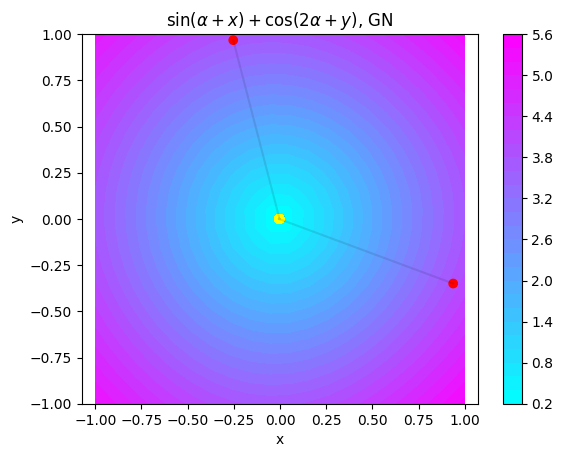

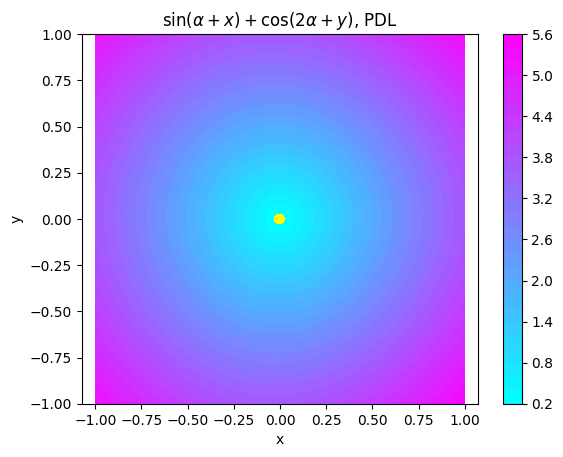

,eps,GN (accuracy),GN (iters),GN (calls),GN (grads),PDL (accuracy),PDL (iters),PDL (calls),PDL (grads)
0,1.000000e-01,0.004193,4,4,4,0.980006,2,2,2
1,3.359818e-02,0.004193,4,4,4,0.046275,95,95,95
2,1.128838e-02,0.004358,4,4,4,0.005600,101,101,101
3,3.792690e-03,0.004358,4,4,4,0.005771,102,102,102
4,1.274275e-03,0.004358,4,4,4,0.005834,102,102,102
5,4.281332e-04,0.004397,5,5,5,0.005834,102,102,102
6,1.438450e-04,0.004397,5,5,5,0.005834,102,102,102
7,4.832930e-05,0.002619,6,6,6,0.005842,103,103,103
8,1.623777e-05,0.004444,8,8,8,0.004248,105,105,105
9,5.455595e-06,0.005916,9,9,9,0.004345,106,106,106


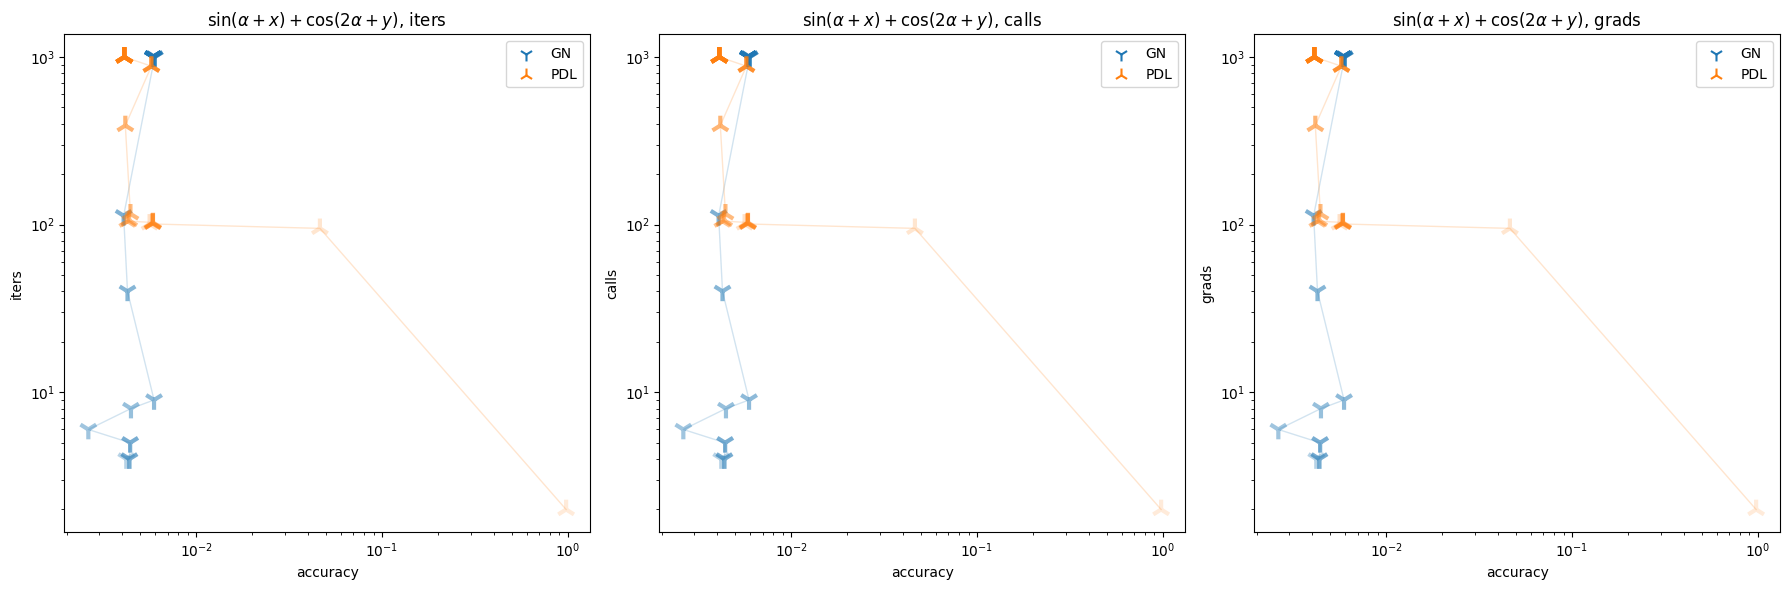

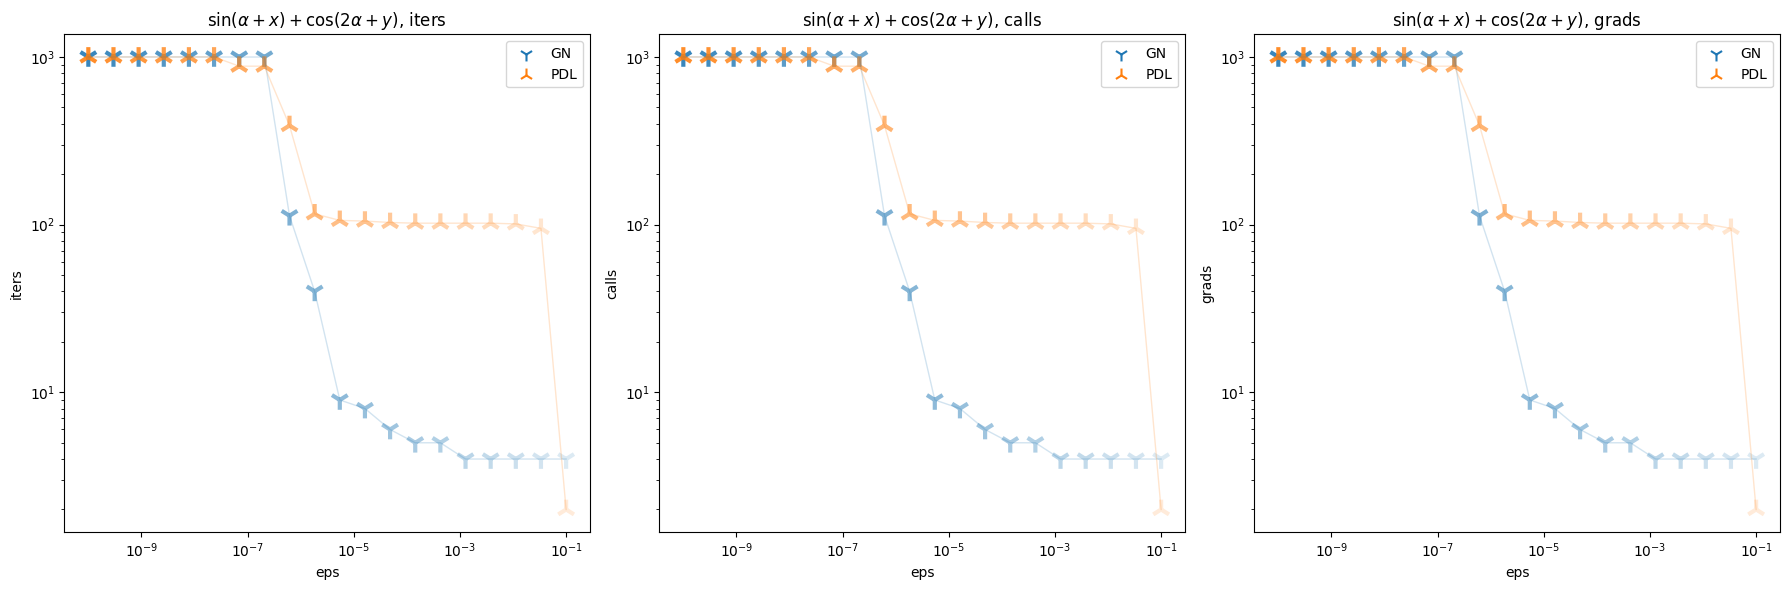

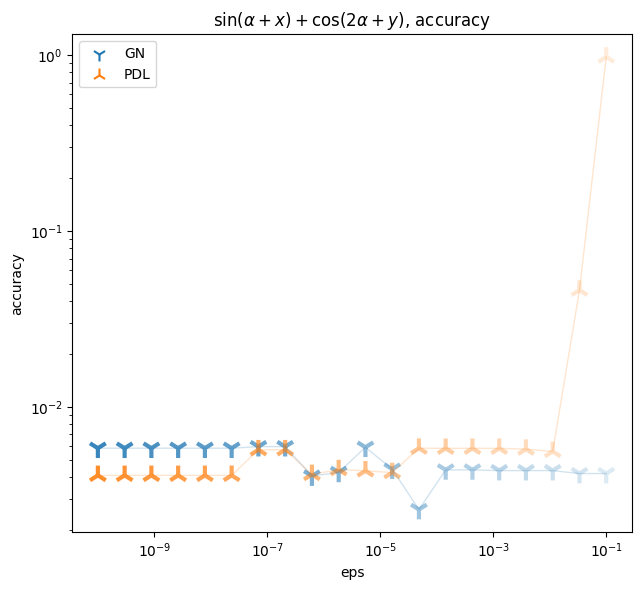

$\cos(\exp(\alpha+x)))+\sin(\exp(2\alpha+y)))$

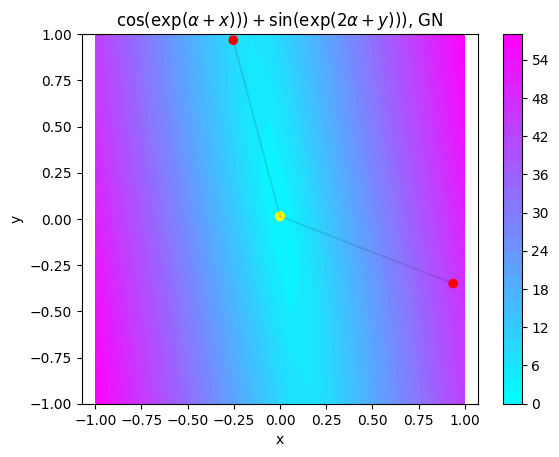

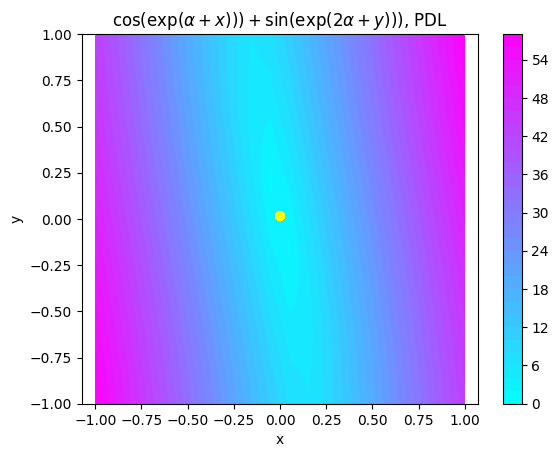

,eps,GN (accuracy),GN (iters),GN (calls),GN (grads),PDL (accuracy),PDL (iters),PDL (calls),PDL (grads)
0,1.000000e-01,0.014566,4,4,4,0.700288,50,50,50
1,3.359818e-02,0.014566,4,4,4,0.014566,123,123,123
2,1.128838e-02,0.014566,4,4,4,0.014566,124,124,124
3,3.792690e-03,0.014566,4,4,4,0.014566,124,124,124
4,1.274275e-03,0.014566,4,4,4,0.014566,124,124,124
5,4.281332e-04,0.014566,5,5,5,0.014566,124,124,124
6,1.438450e-04,0.014566,5,5,5,0.014566,124,124,124
7,4.832930e-05,0.014566,5,5,5,0.014566,124,124,124
8,1.623777e-05,0.014566,5,5,5,0.014566,124,124,124
9,5.455595e-06,0.014566,5,5,5,0.014566,124,124,124


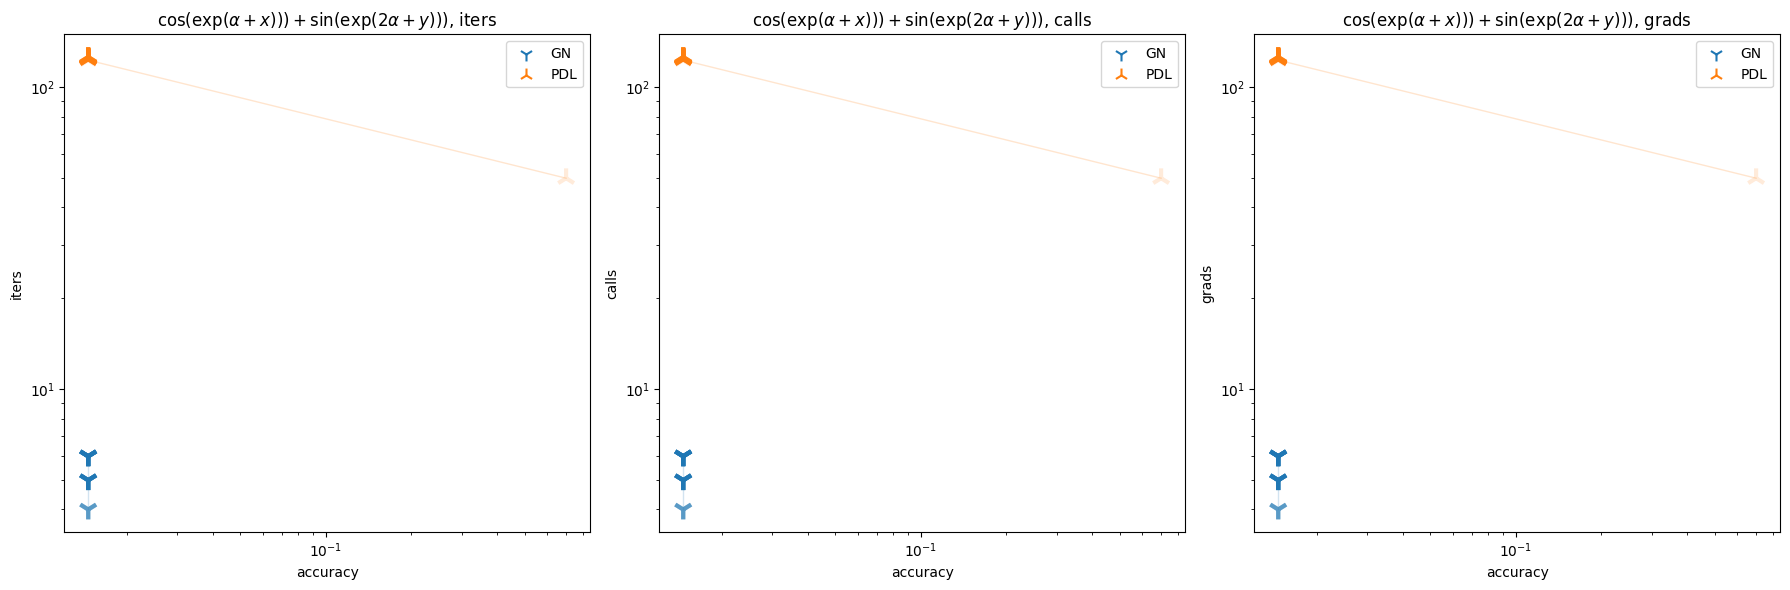

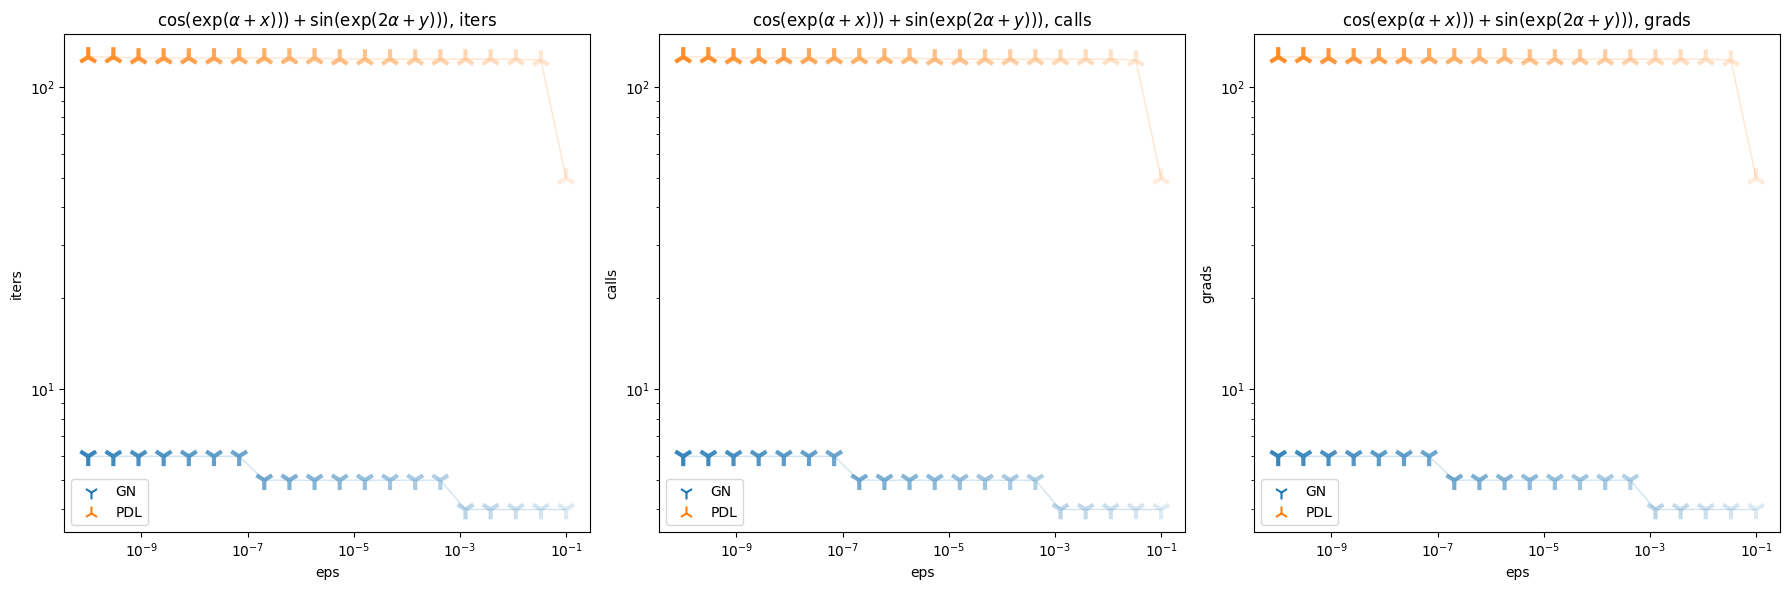

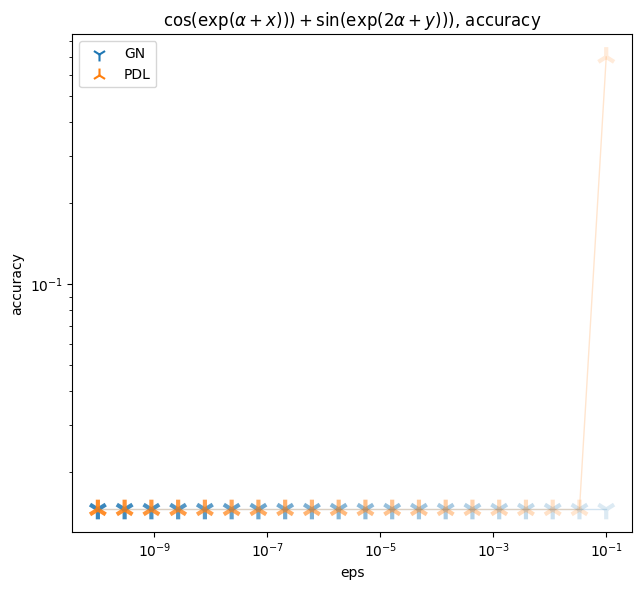

In [116]:
# a, b
functions = [
    (f_a, r"$\sin(\alpha+x)+\cos(2\alpha+y)$"),
    (f_b, r"$\cos(\exp(\alpha+x)))+\sin(\exp(2\alpha+y)))$"),
]
methods = [
    (gauss_newton_method, "GN"),
    (powell_dogleg_method, "PDL"),
]


def make_tables(
    functions: list[tuple[Callable, str]],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_tables: bool = False,
):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]
    x = np.linspace(-10,10,30)
    noise = np.random.normal(x.shape)*0.001
    for f, f_name in functions:
        y = f(x,np.array([0.,0.]))+noise
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:
            def fp(p):
                return np.sum((f(x,p)-y)**2)**0.5
            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                xw, yw = np.meshgrid(xl, yl)
                z = 0 * xw * yw
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = fp(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(xw, yw, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(xw, yw, z, levels=levels, cmap="cool")
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # y = f(x, p) + noise

                    # solve
                    p = point.copy()
                    result, iters, calls, grad_calls, trajectory = method(
                        f, p,x,y, eps=eps, info=True
                    )
                    if ideps + 1 == len(EPS):
                        trajectory = np.array(trajectory)
                        xw, yw = trajectory.T[0], trajectory.T[1]
                        # print(x[0],y[0])
                        xw, yw = xw[::5], yw[::5]
                        c = [(q / len(xw)) ** 0.25 for q in range(len(xw))]
                        plt.plot(xw, yw, color="black", alpha=0.1)
                        plt.scatter(xw, yw, c=c, cmap="autumn")
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("accuracy")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["accuracy"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()


make_tables(functions, methods, plot_tables=True)


#### 4

Use arbitrary methods from previous laboratory work and compare them in terms of effectiveness with the methods implemented in this work.


In [117]:
def gd_constant_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    eps: float = 1e-9,
    info=False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x) < eps:
            break

        trajectory.append(x.copy())
        iters += 1
        grad_calls += 1

        x -= lr * grad(f, x)

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x


In [118]:
def golden_section_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False
):
    iter_count, f_call_count = 0, 0
    if b < a:
        a, b = b, a
    # golden ratio
    gr = (5**0.5 - 1) / 2

    iter_count += 1
    f_call_count += 2
    x = b - (b - a) * gr
    y = a + (b - a) * gr
    fx = f(x)
    fy = f(y)
    while b - a > eps:
        iter_count += 1
        f_call_count += 1
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * gr
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * gr
            fy = f(y)

    res = (b + a) / 2
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [119]:
def conjugate_gradient(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float = 0.1,
    method: str = "golden_section",
    max_it: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    max_subit: int = None,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if max_subit is None:
        max_subit = len(x0)
    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(max_it):
        if np.linalg.norm(x) < eps:
            break
        grad_calls += 1
        g = grad(f, x)
        r0 = -g
        d = r0
        for k in range(max_subit):
            if np.linalg.norm(x) < eps:
                break

            lr, iter_count, f_call_count, unsertainty = search_method(
                lambda y: f(x + y * d), 0, max_lr, eps=eps, info=True
            )
            iters += 1
            calls += f_call_count
            grad_calls += 1
            trajectory.append(x.copy())

            x += lr * d
            r1 = -grad(f, x)
            # Polak-Ribiere
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                beta = r1.T @ (r1 - r0) / (r0.T @ r0)
            if np.isnan(beta):
                beta = 0.0
            beta = max(beta, 0.0)
            d = r1 + beta * d
            r0 = r1

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x


In [122]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros_like(x, dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        # print(f(x + dx))
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f


In [123]:
def test_gd_simple():
    def f1(x):
        return np.linalg.norm(x) ** 2

    print(gd_constant_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_constant_step(f1, np.random.random(1), 0.1), 0)
    print(conjugate_gradient(f1, np.random.random(1), 0.1))
    assert np.isclose(conjugate_gradient(f1, np.random.random(1), 0.1), 0)


test_gd_simple()


[8.03087622e-10]
[2.17322688e-15]


$\sin(\alpha+x)+\cos(2\alpha+y)$

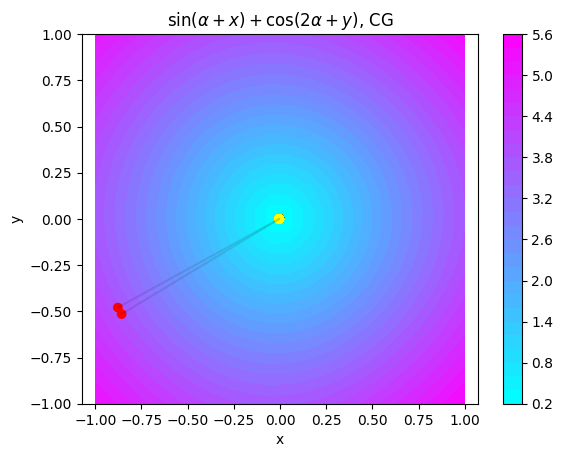

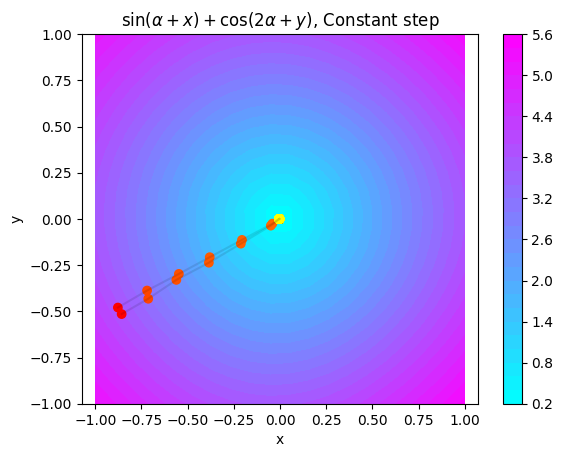

,eps,CG (accuracy),CG (iters),CG (calls),CG (grads),Constant step (accuracy),Constant step (iters),Constant step (calls),Constant step (grads)
0,1.000000e-01,0.021150,5,10,8,0.089702,24,0,24
1,3.359818e-02,0.019165,3,17,5,0.023997,26,0,26
2,1.128838e-02,0.004353,3,24,5,0.006772,27,0,27
3,3.792690e-03,0.003722,25,225,37,0.002773,29,0,29
4,1.274275e-03,0.004536,2000,24000,3000,0.003056,1000,0,1000
5,4.281332e-04,0.004563,2000,28000,3000,0.003056,1000,0,1000
6,1.438450e-04,0.004391,2000,32000,3000,0.003056,1000,0,1000
7,4.832930e-05,0.004412,2000,36000,3000,0.003056,1000,0,1000
8,1.623777e-05,0.004399,2000,42000,3000,0.003056,1000,0,1000
9,5.455595e-06,0.004399,2000,46000,3000,0.003056,1000,0,1000


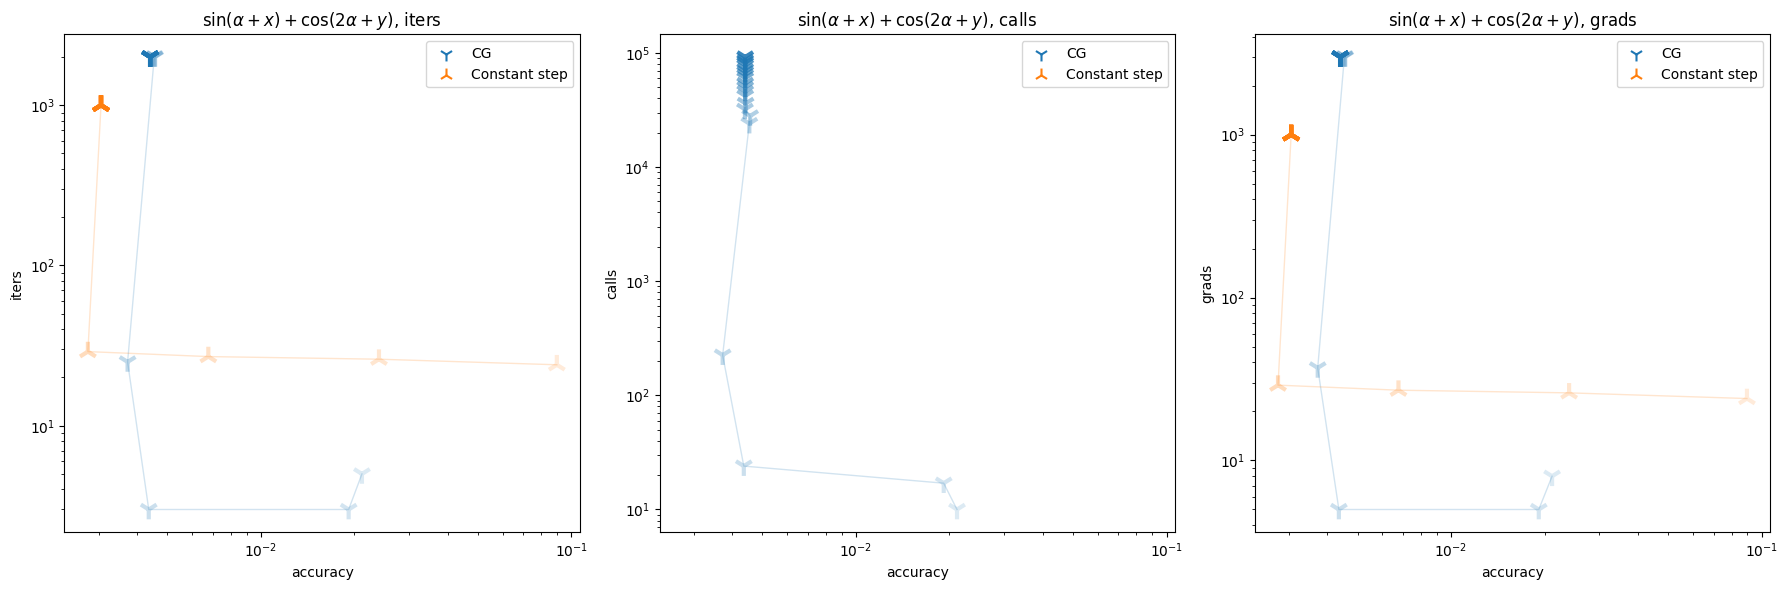

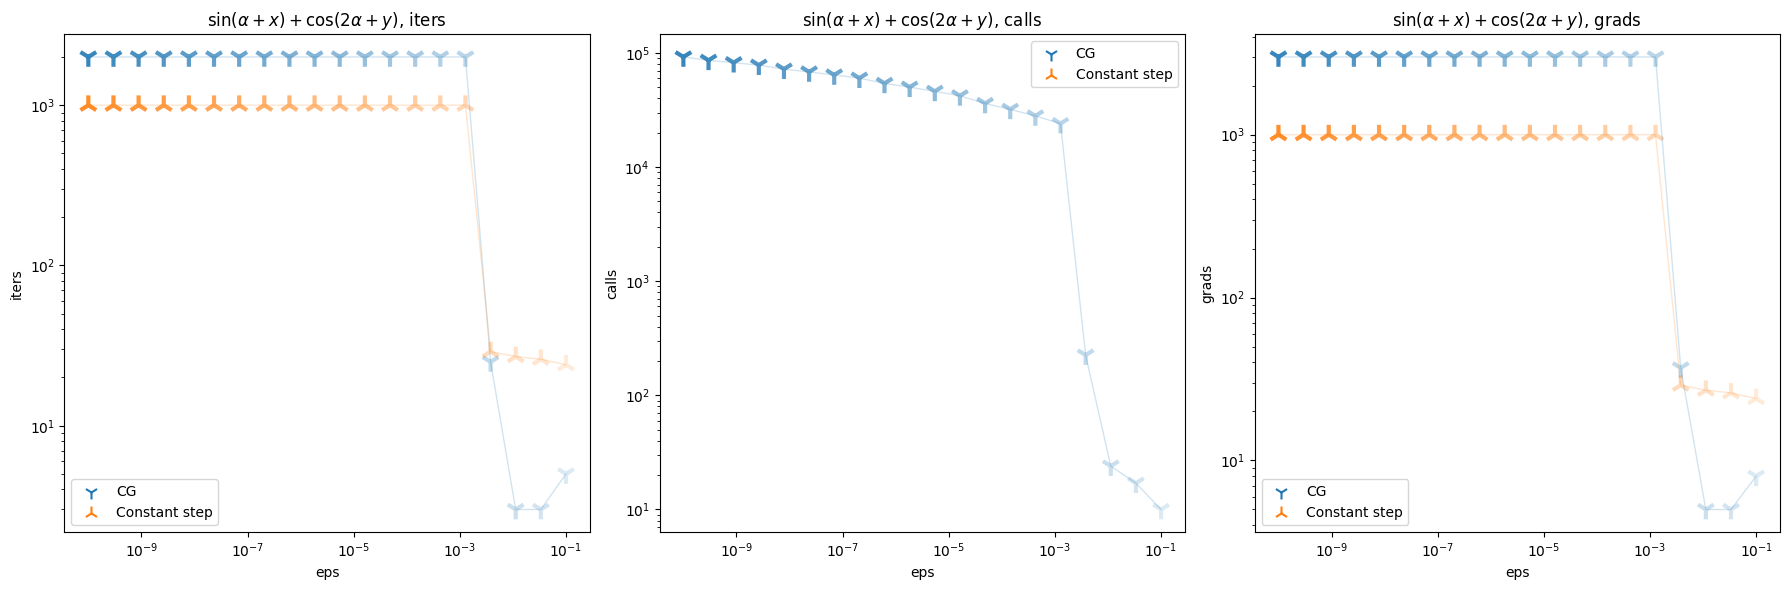

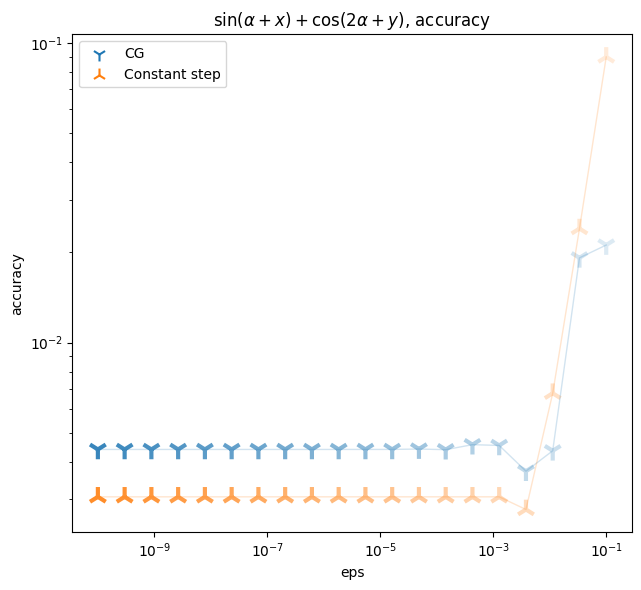

$\cos(\exp(\alpha+x)))+\sin(\exp(2\alpha+y)))$

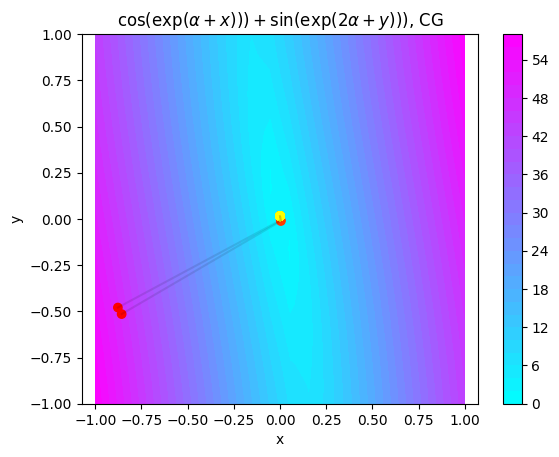

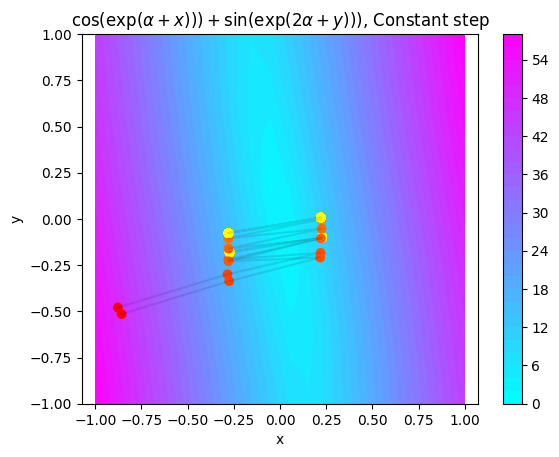

,eps,CG (accuracy),CG (iters),CG (calls),CG (grads),Constant step (accuracy),Constant step (iters),Constant step (calls),Constant step (grads)
0,1.000000e-01,3.916902,2000,4000,3000,0.234564,1000,0,1000
1,3.359818e-02,0.211662,1097,5487,1646,0.234564,1000,0,1000
2,1.128838e-02,0.009411,585,4095,878,0.234564,1000,0,1000
3,3.792690e-03,0.068242,2000,18000,3000,0.234564,1000,0,1000
4,1.274275e-03,0.025221,2000,24000,3000,0.234564,1000,0,1000
5,4.281332e-04,0.017006,2000,28000,3000,0.234564,1000,0,1000
6,1.438450e-04,0.014629,2000,32000,3000,0.234564,1000,0,1000
7,4.832930e-05,0.014683,2000,36000,3000,0.234564,1000,0,1000
8,1.623777e-05,0.014683,2000,42000,3000,0.234564,1000,0,1000
9,5.455595e-06,0.014699,2000,46000,3000,0.234564,1000,0,1000


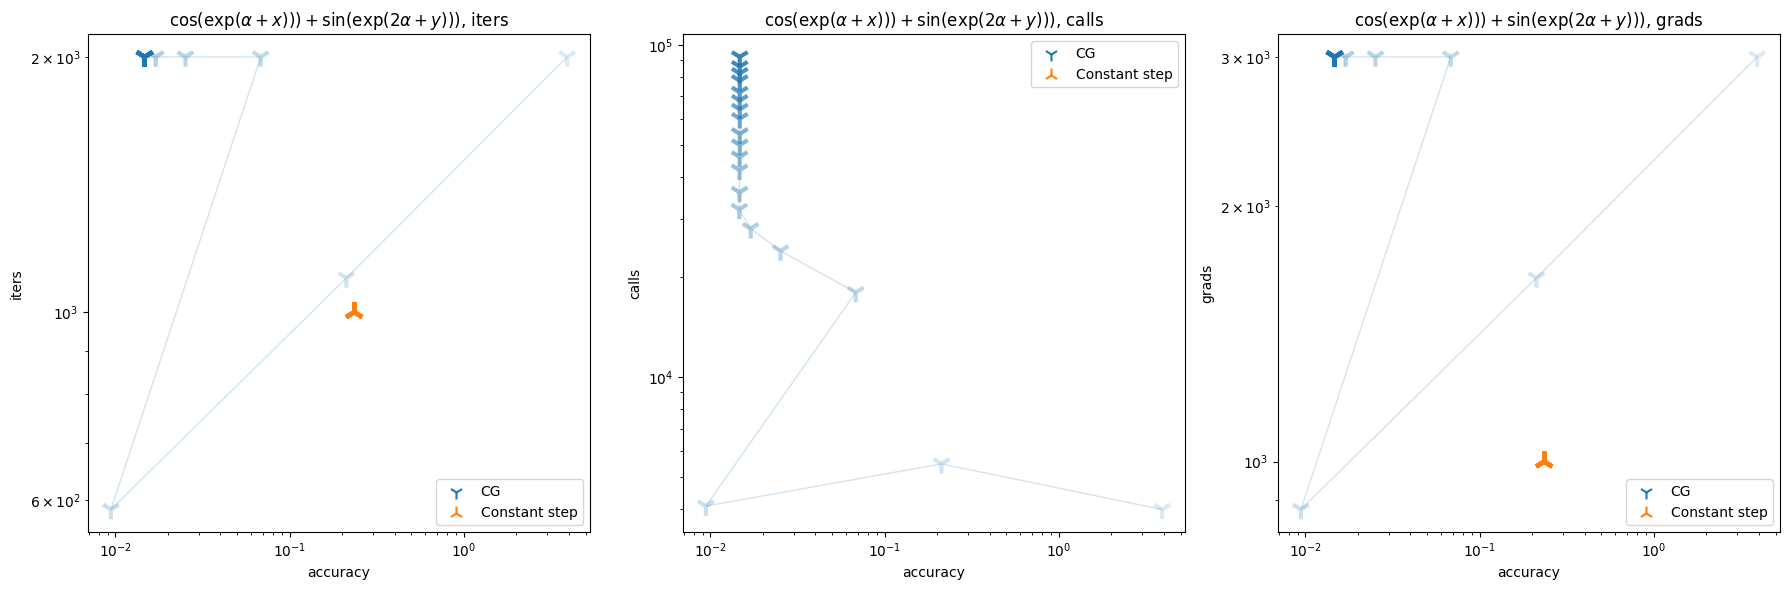

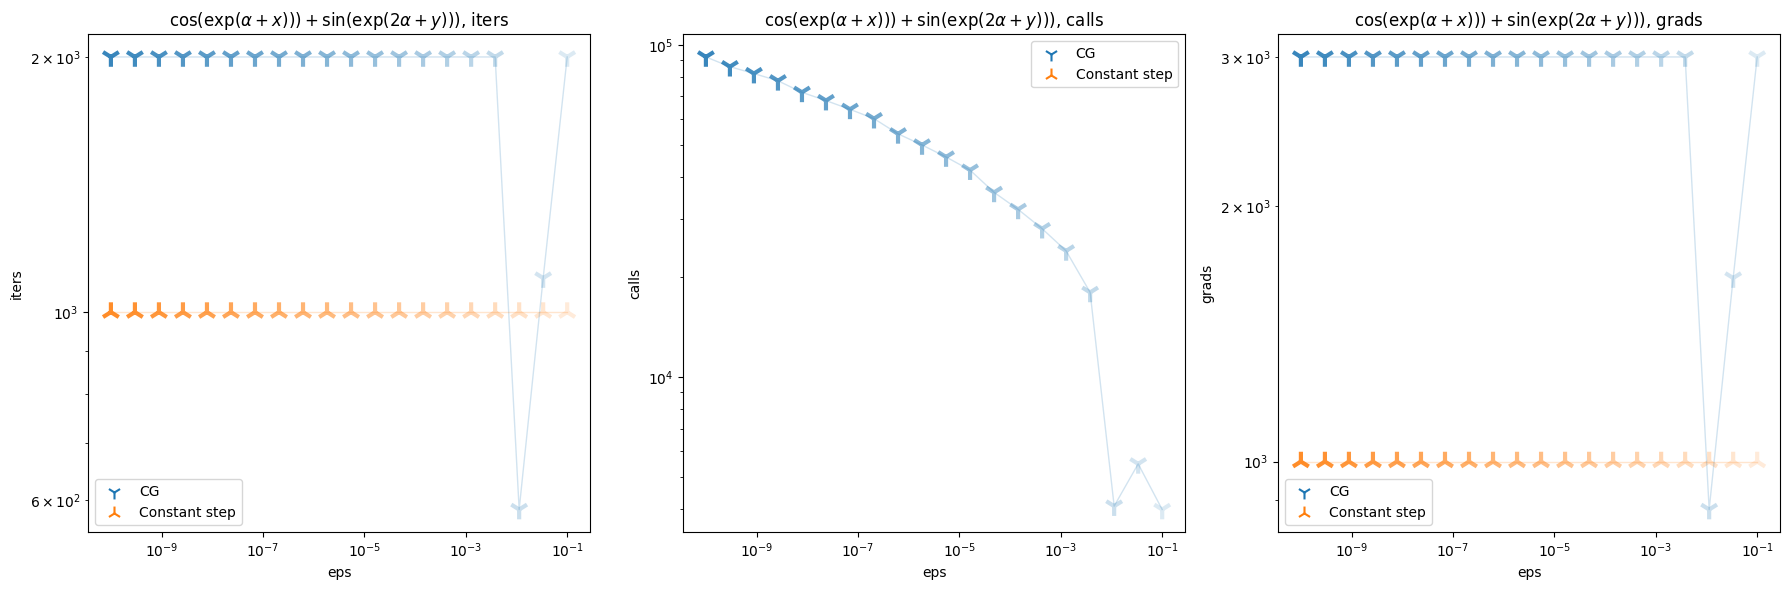

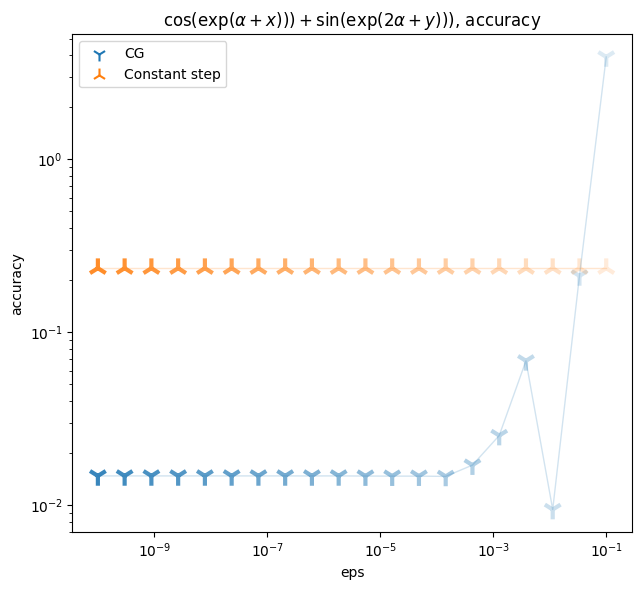

In [124]:
functions = [
    (f_a, r"$\sin(\alpha+x)+\cos(2\alpha+y)$"),
    (f_b, r"$\cos(\exp(\alpha+x)))+\sin(\exp(2\alpha+y)))$"),
]
methods = [
    (conjugate_gradient, "CG"),
    (gd_constant_step, "Constant step"),
]


def make_tables2(
    functions: list[tuple[Callable, str]],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_tables: bool = False,
):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]
    x = np.linspace(-10,10,30)
    noise = np.random.normal(x.shape)*0.001
    for f, f_name in functions:
        y = f(x,np.array([0.,0.]))+noise
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:
            def fp(p):
                return np.sum((f(x,p)-y)**2)**0.5
            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                xw, yw = np.meshgrid(xl, yl)
                z = 0 * xw * yw
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = fp(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(xw, yw, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(xw, yw, z, levels=levels, cmap="cool")
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # y = f(x, p) + noise

                    # solve
                    p = point.copy()
                    result, iters, calls, grad_calls, trajectory = method(
                        lambda p:np.sum((f(x,p)-y)**2)**0.5, p, eps=eps, info=True
                    )
                    if ideps + 1 == len(EPS):
                        trajectory = np.array(trajectory)
                        xw, yw = trajectory.T[0], trajectory.T[1]
                        # print(x[0],y[0])
                        xw, yw = xw[::5], yw[::5]
                        c = [(q / len(xw)) ** 0.25 for q in range(len(xw))]
                        plt.plot(xw, yw, color="black", alpha=0.1)
                        plt.scatter(xw, yw, c=c, cmap="autumn")
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("accuracy")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["accuracy"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()


make_tables2(functions, methods, plot_tables=True)
